# photometry_plot2.ipynb

開口測光したデータをプロットする。横軸は衛星のSys3経度。

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
import matplotlib.patches as patches
from matplotlib.ticker import AutoMinorLocator
import matplotlib.patheffects as pe
import pandas as pd
import os
import copy
import ftpS3
import localtime
import spiceypy as spice
spice.furnsh('kernel/cassMetaK.txt')

fontname = 'Nimbus Sans'
plt.rcParams.update({'font.sans-serif': fontname,
                    'font.family': 'sans-serif',
                     'mathtext.fontset': 'custom',
                     'mathtext.rm': fontname,
                     'mathtext.it': fontname+':italic',
                     # 'mathtext.bf': 'Nimbus Sans:italic:bold',
                     'mathtext.bf': fontname+':bold',
                     'text.kerning_factor': 0,
                     # 'font.size': 19,
                     })
params = {
    # 'lines.markersize': 1,
    # 'lines.linewidth': 1,
    'axes.linewidth': 2,
    'xtick.major.size': 5,
    'xtick.minor.size': 3.5,
    'xtick.major.width': 2.0,
    'xtick.minor.width': 1.25,
    'ytick.major.size': 5,
    'ytick.minor.size': 3,
    'ytick.major.width': 2.0,
    'ytick.minor.width': 1.25,
}
plt.rcParams.update(params)

# cpalette = ['#8ecae6', '#ffb703', '#023047', '#fb8500', '#219ebc']
cpalette = ['#0F4C81', '#FF6F61', '#645394',
         '#84BD00', '#F6BE00', '#F7CAC9', '#0F80E6']
cpalette = ['#184678', '#005261', '#C00000', '#E88B00', '#F25A00', '#2F397D', '#A3BDDA', '#9FC0B4', '#F3B5A8', '#EECA77', '#EFA785', '#AAACD4']
cpalette = ['#E7534B', '#EF8C46', '#F7D702', '#3C8867', '#649CDB', '#5341A5', '#A65FAC', '#A2AAAD']

# Color universal design
cud4 = ['#FF3300', '#FFF100', '#03AF7A', '#005AFF', '#4DC4FF', '#FF8082', '#F6AA00', '#990099', '#804000']
cud4bs = ['#FFCABF', '#FFFF80', '#D8F255', '#BFE4FF', '#FFCA80', '#77D9A8', '#C9ACE6', '#84919E']

In [2]:
# Set legend shadow
def legend_shadow(fig, ax, legend, dx, dy):

  frame = legend.get_window_extent()

  xmin, ymin = fig.transFigure.inverted().transform((frame.xmin, frame.ymin))
  xmax, ymax = fig.transFigure.inverted().transform((frame.xmax, frame.ymax))

  # plot patch shadow
  rect = patches.Rectangle((xmin+dx, ymin+dy), xmax-xmin, ymax-ymin, 
                          transform=fig.transFigure,
                          edgecolor='k', facecolor='k',
                          clip_on=False)
  ax.add_patch(rect)

  return None

In [3]:
north_doy = ['14/006_v06', '14/013_v13', '14/016_v12', '22/271_v18', '22/274_v17']
south_doy = ['22/185_v09', '22/310_v19', '22/349_v23']
south_doy = ['22/185_v09_MAW', '22/185_v09', '22/310_v19', '22/349_v23']
# south_doy = ['22/185_v09', '22/185_v09_MAW']

nbkg_doy = ['14/001_v01', '14/002_v02', '14/005_v05', '14/006_v06', '14/013_v13', '14/016_v12', '22/185_v10', '22/228_v13', '22/271_v18', '22/274_v17', '22/309_v20', '22/349_v24']
sbkg_doy = ['22/140_v03', '22/185_v09', '22/186_v11', '22/229_v14', '22/310_v19', '22/311_v21', '22/349_v23']

def load(csvname0):
    df = pd.read_csv(csvname0, sep='\t')
    utc = df.loc[:, 'date']                                 # UTC date
    efplat = df.loc[:, 'lat [deg]'].values                  # EFP latitude [deg]
    efpwlong = df.loc[:, 'wlong [deg]'].values              # EFP System III longitude [deg]
    moons3 = df.loc[:, 'Moon S3 [deg]'].values              # Europa's System III longitude [deg]
    final_phot_ave = df.loc[:, 'spot brightness [kR]']      # EFP brightness [kR]
    annulus_median = df.loc[:, 'local background [kR]']     # local background [kR]
    
    b0_arr = np.zeros(len(final_phot_ave))
    b1_arr = np.zeros(len(final_phot_ave))
    efplat0_arr = np.zeros(len(final_phot_ave))
    efpwlong0_arr = np.zeros(len(final_phot_ave))
    moons30_arr = np.zeros(len(final_phot_ave))
    for i in range(len(final_phot_ave)):
        if final_phot_ave[i] != '0':
            b0_arr[i] = final_phot_ave[i]
            b1_arr[i] = annulus_median[i]
            efplat0_arr[i] = efplat[i]
            efpwlong0_arr[i] = efpwlong[i]
            moons30_arr[i] = moons3[i]
        else:
            continue
    
    return utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr

JRM33計算結果

磁気赤道面crossingのSys3 [deg] 110.61452513966482

磁場成分 Br 最大のSys3 [deg] 189.05027932960894

磁気赤道面crossingのSys3 [deg] 281.56424581005587

### 北半球 発光強度 (横軸: EuropaのS3経度)

In [4]:
hem = 'North'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
    bon17 = '0006'
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
    bon17 = '0007'
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

xing_s3wlon_110 = ftpS3.ftpS3().FPW(114.2, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(114.2+180, satoval, 'EUROPA')

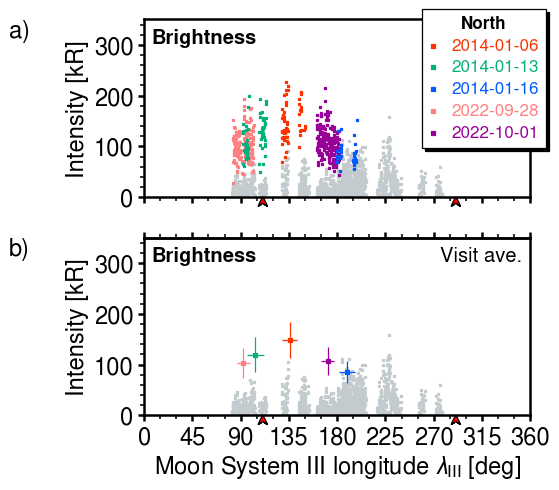

In [5]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].set_ylim(0,350)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.linspace(0,300,4,dtype=int))
    ax[i].set_yticklabels(np.linspace(0,300,4,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, r'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2014-01-06', '2014-01-13', '2014-01-16']+['2022-09-28', '2022-10-01']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=10-i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=1,
                    markerscale=3.5,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    ax[1].scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
    ax[1].errorbar(moons30_ave, b0_ave, xerr=moons30_std, yerr=b0_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()

Count rate:  0.03287442882195909
Count rate:  0.02641699123346924
Count rate:  0.018838330381669113
Count rate:  0.022805678783335694
Count rate:  0.02381089991585443


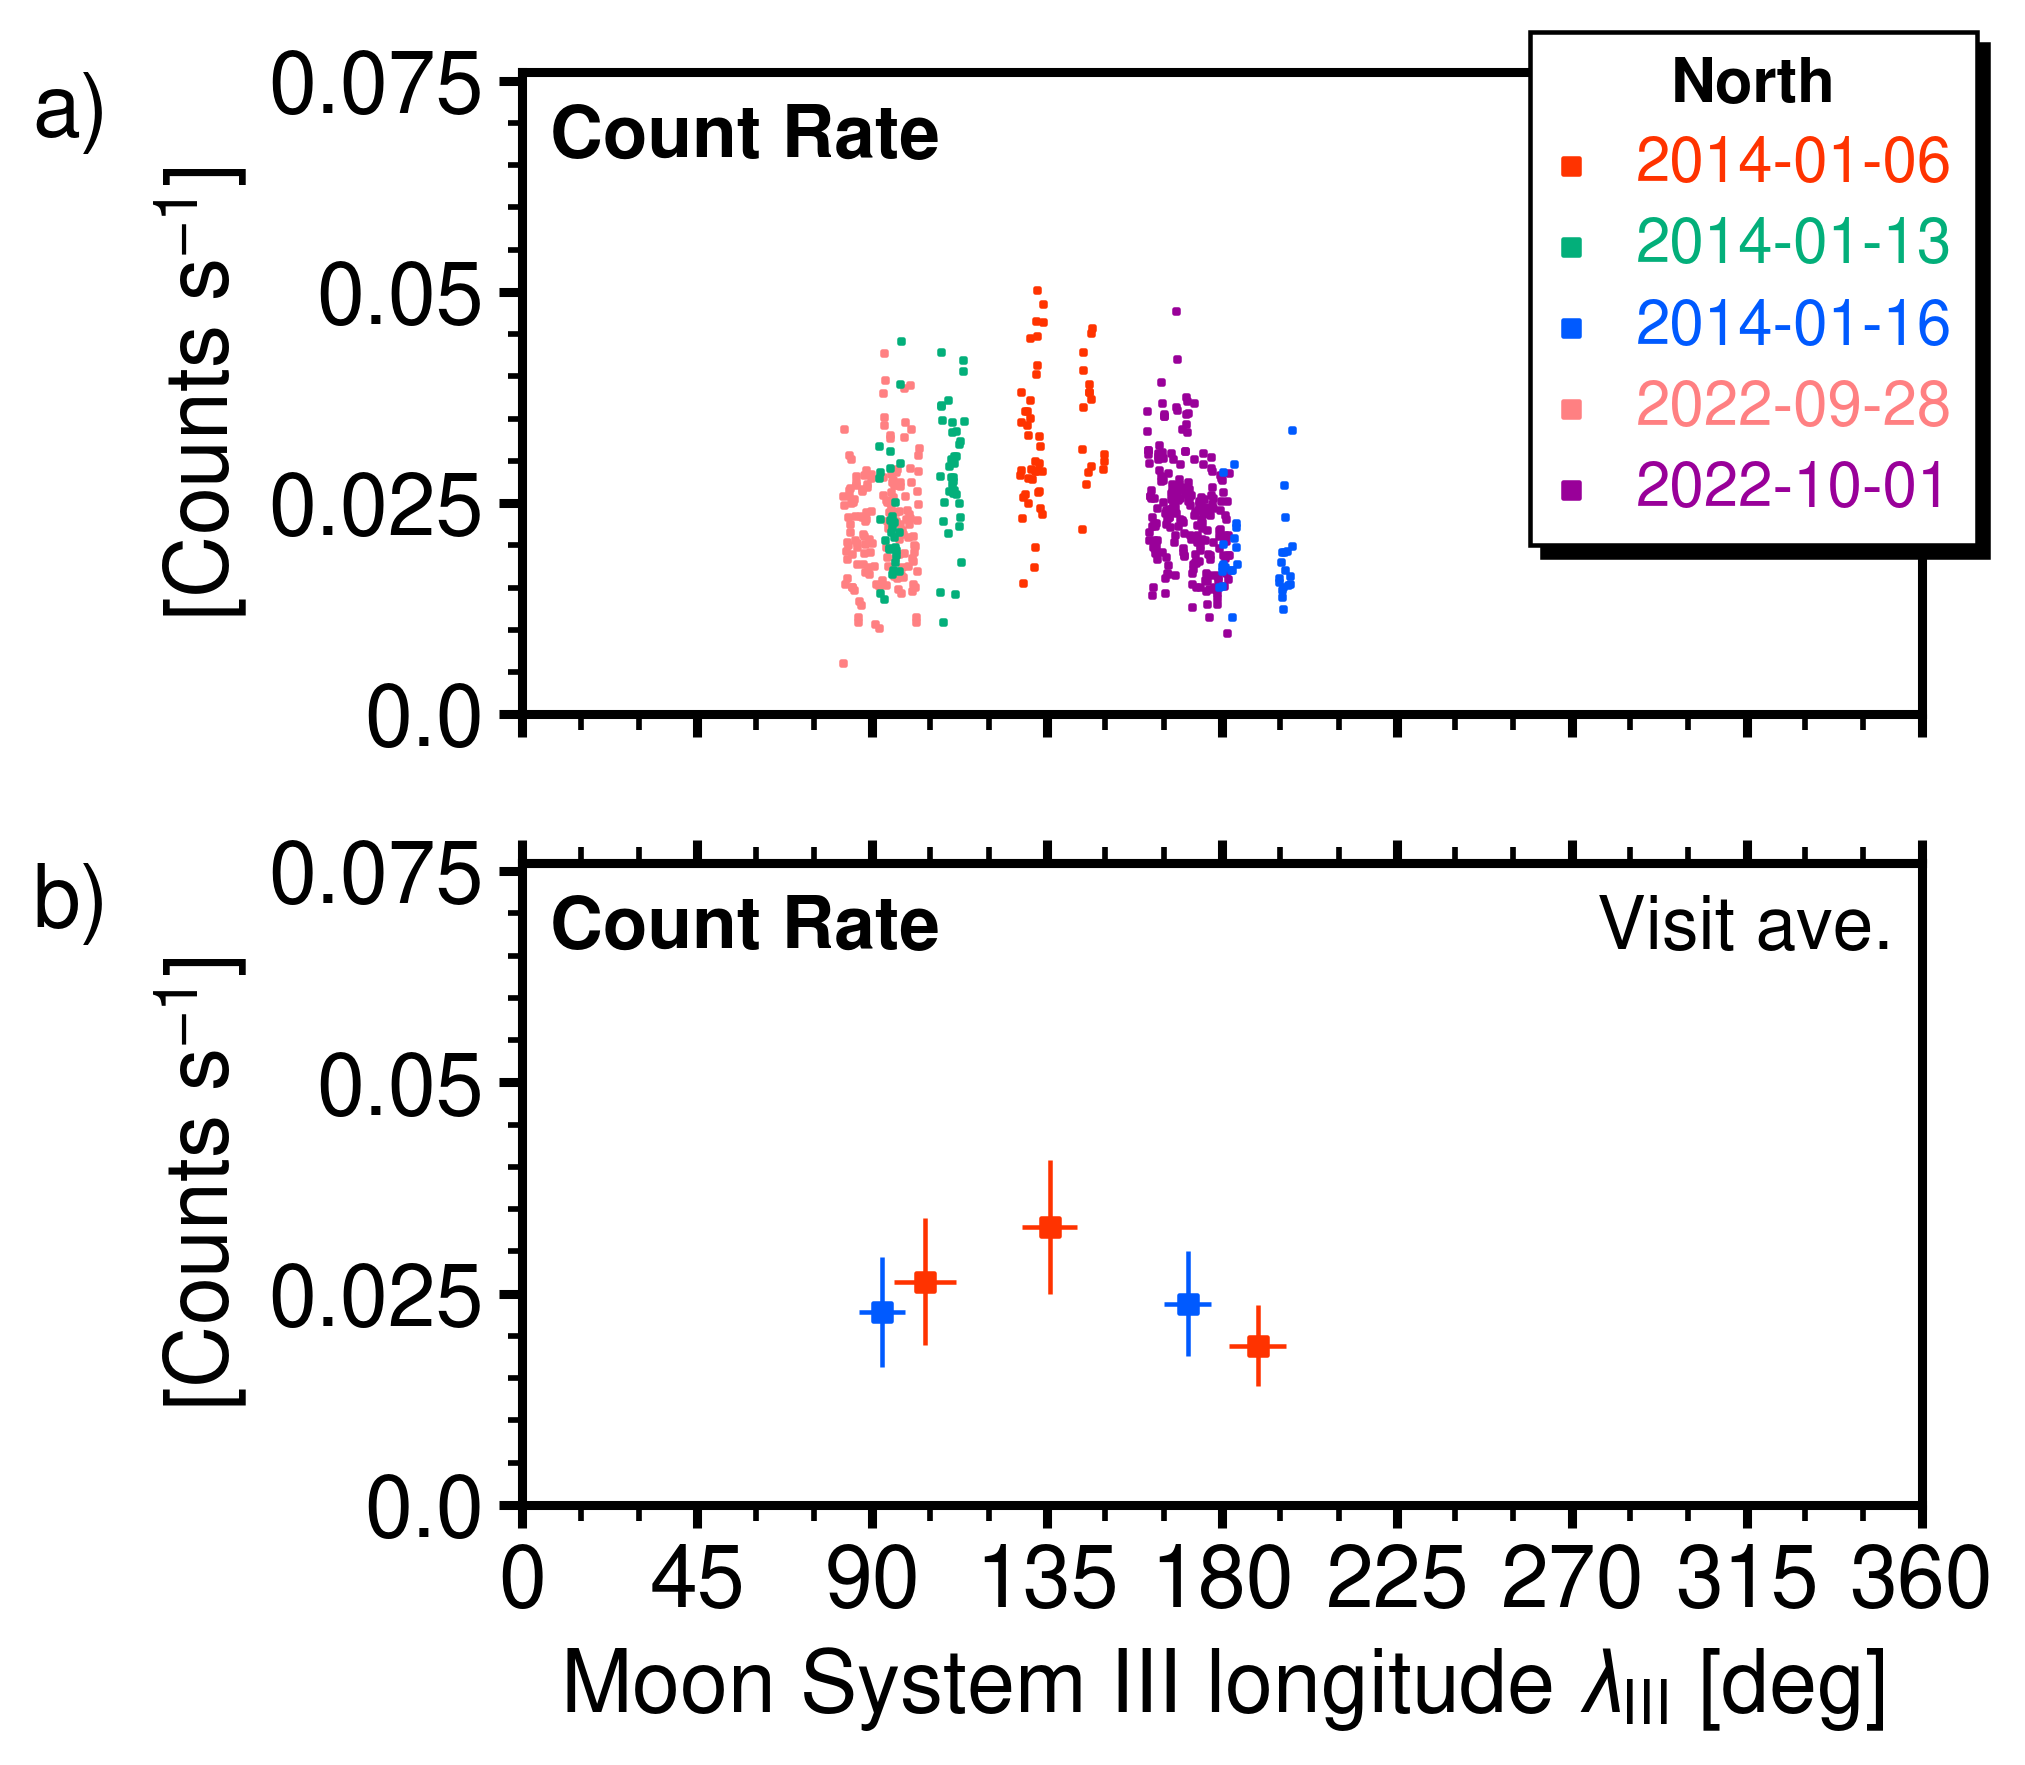

In [6]:
# ----- カウントレート -----
ctr2kr = 4523       # Color ratio = 2.5 (Table 1 in Gustin+2012)

# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=326)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].set_ylim(0,0.076)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.arange(0,0.076,0.025))
    ax[i].set_yticklabels(np.array([0,0.025, 0.05, 0.075]))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel(r'[Counts s$^{-1}$]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, r'Count Rate', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2014-01-06', '2014-01-13', '2014-01-16']+['2022-09-28', '2022-10-01']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr/ctr2kr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=10-i)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=1,
                    markerscale=3.5,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Count Rate', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    ax[1].scatter(moons30_ave, b0_ave/ctr2kr, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
    ax[1].errorbar(moons30_ave, b0_ave/ctr2kr, xerr=moons30_std, yerr=b0_std/ctr2kr,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)
    print('Count rate: ', b0_ave/ctr2kr)
    
plt.show()

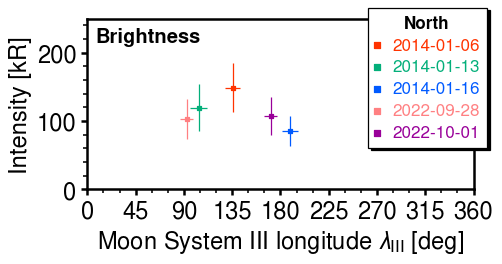

In [7]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(figsize=(5,2.5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']

ax.set_xlim(0,360)
ax.set_ylim(0,250)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0,201,100,dtype=int))
ax.set_yticklabels(np.arange(0,201,100,dtype=int))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)

# ======
# X AXIS
# ======
ax.set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax.text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2014-01-06', '2014-01-13', '2014-01-16']+['2022-09-28', '2022-10-01']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    ax.scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doyname[i], zorder=1)
    ax.errorbar(moons30_ave, b0_ave, xerr=moons30_std, yerr=b0_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)

legend_fsize = fontsize*0.72
legend1 = ax.legend(loc='upper center',
                    ncol=1,
                    markerscale=1.25,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.25,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax, legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1
    
plt.show()

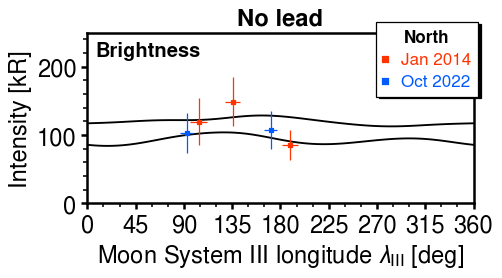

In [8]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(figsize=(5,2.5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']

ax.set_title('No lead', fontsize=fontsize, weight='bold')
ax.set_xlim(0,360)
ax.set_ylim(0,250)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0,201,100,dtype=int))
ax.set_yticklabels(np.arange(0,201,100,dtype=int))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)

# ======
# X AXIS
# ======
ax.set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# BRIGHTNESS
# ==========
ax.text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
doyname =['Jan 2014', None, None]+['Oct 2022', None]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    ax.scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doyname[i], zorder=1)
    ax.errorbar(moons30_ave, b0_ave, xerr=moons30_std, yerr=b0_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)

# =====
# POWER
# =====
pwr_14 = np.loadtxt('data/Power/2014_R4.txt')
pwr_22 = np.loadtxt('data/Power/2022_R4.txt')
ax.plot(pwr_14[0,:], pwr_14[1,:]*100/(4.5E+10), color='k', zorder=0.8)
ax.plot(pwr_22[0,:], pwr_22[1,:]*100/(4.5E+10), color='k', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax.legend(loc='upper center',
                    ncol=1,
                    markerscale=1.25,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.25,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax, legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
labelcolor = [cud4[0], cud4[3]]
for leg1text in legend1.get_texts():
    leg1text.set_color(labelcolor[i])
    i += 1
    
plt.show()

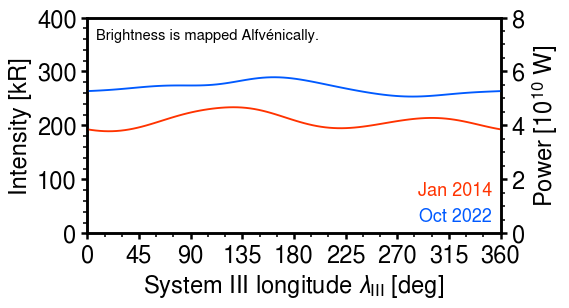

In [9]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(figsize=(5.3,3), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']

ax.set_xlim(0,360)
ax.set_ylim(0,400)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0,401,100,dtype=int))
ax.set_yticklabels(np.arange(0,401,100,dtype=int))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)

# ======
# X AXIS
# ======
ax.set_xlabel(r"System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# BRIGHTNESS
# ==========
ax.text(0.02, 0.95, 'Brightness is mapped Alfvénically.', 
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax.transAxes,
           fontsize=fontsize*0.62)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
doyname =['Jan 2014', None, None]+['Oct 2022', None]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)

    # リード角補正
    lead_data = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    eq_leadangle = lead_data[1,:]   # lead angle [deg]
    if doy[i] == '22/271_v18':
        # なぜかリード角のデータと1行目が合わない
        efplat0_arr = efplat0_arr[1:]
        efpwlong0_arr = efpwlong0_arr[1:]
        moons30_arr = moons30_arr[1:]
        b0_arr = b0_arr[1:]
        b1_arr = b1_arr[1:]
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    moon_leadback = moons30_arr-eq_leadangle
    moon_leadback_ave = np.average(moon_leadback)
    moon_leadback_std = np.std(moon_leadback)
    
    ax.scatter(moon_leadback, b0_arr, marker=',', s=0.5, c=cud4_N[i], label=doyname[i], zorder=1)
    # ax.scatter(moon_leadback_ave, b0_ave, marker=',', s=15, c=cud4_N[i], label=doyname[i], zorder=1)
    """ax.errorbar(moon_leadback_ave, b0_ave,
                xerr=moons30_std, yerr=b0_std, label=doyname[i],
                marker='s', markersize=3, mfc=cud4_N[i], mec=cud4_N[i],
                linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, zorder=1.5)"""

# =====
# POWER
# =====
pwr_14 = np.loadtxt('data/Power/2014_R4.txt')
pwr_22 = np.loadtxt('data/Power/2022_R4.txt')
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_ylim(0,8)
ax2.set_yticks(np.arange(0,8+1,2,dtype=int))
ax2.set_yticklabels(np.arange(0,8+1,2,dtype=int))
ax2.set_ylabel(r'Power [$10^{10}$ W]', fontsize=fontsize)
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))  # minor ticks
ax2.plot(pwr_14[0,:], pwr_14[1,:]*1E-10, color=cud4[0], zorder=0.8)
ax2.plot(pwr_22[0,:], pwr_22[1,:]*1E-10, color=cud4[3], zorder=0.8)
ax2.yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記

"""# legend
legend_fsize = fontsize*0.5
handles1, labels1 = ax.get_legend_handles_labels()
legend1 = ax2.legend(handles1, labels1, loc='upper center',
                    ncol=1,
                    markerscale=1,
                    bbox_to_anchor=(0.58, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.8,)
# legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax2, legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
labelcolor = [cud4[0], cud4[3]]
for leg1text in legend1.get_texts():
    leg1text.set_color(labelcolor[i])
    i += 1
"""

ax.text(0.98, 0.20, 'Jan 2014', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.76)
ax.text(0.98, 0.08, 'Oct 2022', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.76)
plt.show()

S3 long. [deg]: 133.42524957613273
brightness [kR]: 148.69104156172097
1 sigma [kR]: 35.95013950014683
S3 long. [deg]: 98.28193689058392
brightness [kR]: 119.48405134898138
1 sigma [kR]: 34.19465180990543
S3 long. [deg]: 187.72694177182828
brightness [kR]: 85.2057683162894
1 sigma [kR]: 21.60489879738368
S3 long. [deg]: 83.82101689698841
brightness [kR]: 103.65974592311026
1 sigma [kR]: 28.741229499
S3 long. [deg]: 168.0198387495764
brightness [kR]: 107.69670031940959
1 sigma [kR]: 27.960501902391933


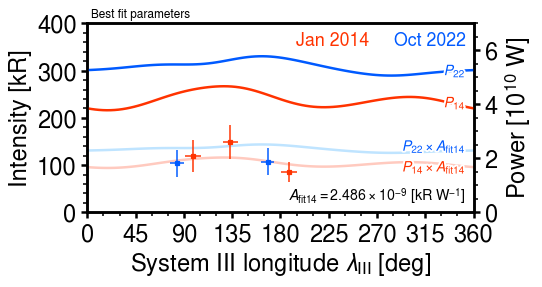

In [10]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(figsize=(5.0,2.7), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']

ax.set_xlim(0,360)
ax.set_ylim(0,400)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0,401,100,dtype=int))
ax.set_yticklabels(np.arange(0,401,100,dtype=int))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)

# ======
# X AXIS
# ======
ax.set_xlabel(r"System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# BRIGHTNESS
# ==========
ax.text(0.01, 1.015, 'Best fit parameters', 
           color='k',
           horizontalalignment='left',
           verticalalignment='bottom',
           transform=ax.transAxes,
           fontsize=fontsize*0.5)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
doyname =['Jan 2014', None, None]+['Oct 2022', None]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)

    # リード角補正
    lead_data = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    eq_leadangle = lead_data[1,:]   # lead angle [deg]
    if doy[i] == '22/271_v18':
        # なぜかリード角のデータと1行目が合わない
        efplat0_arr = efplat0_arr[1:]
        efpwlong0_arr = efpwlong0_arr[1:]
        moons30_arr = moons30_arr[1:]
        b0_arr = b0_arr[1:]
        b1_arr = b1_arr[1:]
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    moon_leadback = moons30_arr-eq_leadangle
    moon_leadback_ave = np.average(moon_leadback)
    moon_leadback_std = np.std(moon_leadback)
    
    # ax.scatter(moon_leadback, b0_arr, marker=',', s=0.5, c=cud4_N[i], label=doyname[i], zorder=1)
    # ax.scatter(moon_leadback_ave, b0_ave, marker=',', s=15, c=cud4_N[i], label=doyname[i], zorder=1)
    ax.errorbar(moon_leadback_ave, b0_ave,
                xerr=moon_leadback_std, yerr=b0_std, label=doyname[i],
                marker='s', markersize=3.5, mfc=cud4_N[i], mec=cud4_N[i],
                linestyle='none', ecolor=cud4_N[i], elinewidth=1.2, zorder=1.5)
    print('S3 long. [deg]:', moon_leadback_ave)
    print('brightness [kR]:', b0_ave)
    print('1 sigma [kR]:', b0_std)

# =====
# POWER
# =====
pwr_14 = np.loadtxt('data/Power/2014_R4.txt')
pwr_22 = np.loadtxt('data/Power/2022_R4.txt')
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_ylim(0,7)
ax2.set_yticks(np.arange(0,7+1,2,dtype=int))
ax2.set_yticklabels(np.arange(0,7+1,2,dtype=int))
ax2.set_ylabel(r'Power [$10^{10}$ W]', fontsize=fontsize)
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))  # minor ticks
ax2.plot(pwr_14[0,:], pwr_14[1,:]*1E-10, linewidth=2.0, color=cud4[0], zorder=0.8)
ax2.plot(pwr_22[0,:], pwr_22[1,:]*1E-10, linewidth=2.0, color=cud4[3], zorder=0.8)
ax2.yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記

# ==============
# BRIGHTNESS FIT
# ==============
min_factor = 2.485714285714286e-09
ax.plot(pwr_14[0,:], pwr_14[1,:]*min_factor, linewidth=2.0, color=cud4bs[0], zorder=0.8)
ax.plot(pwr_22[0,:], pwr_22[1,:]*min_factor, linewidth=2.0, color=cud4bs[3], zorder=0.8)

# =======
# CAPTION
# =======
ax.text(0.73, 0.91, 'Jan 2014', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.75)
ax.text(0.98, 0.91, 'Oct 2022', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.75)
ax2.text(0.98, 0.58, r'$P_{14}$', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax2.text(0.98, 0.75, r'$P_{22}$', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax2.text(0.98, 0.24, r'$P_{14}\times A_{\rm fit14}$', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax2.text(0.98, 0.35, r'$P_{22}\times A_{\rm fit14}$', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax.text(0.98, 0.03, r'$A_{\rm fit14} = 2.486 \times 10^{-9}$ [kR W$^{-1}$]', 
           color='k',
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax.transAxes,
           fontsize=fontsize*0.6)

plt.show()

S3 long. [deg]: 133.42524957613273
brightness [kR]: 148.69104156172097
1 sigma [kR]: 35.95013950014683
S3 long. [deg]: 98.28193689058392
brightness [kR]: 119.48405134898138
1 sigma [kR]: 34.19465180990543
S3 long. [deg]: 187.72694177182828
brightness [kR]: 85.2057683162894
1 sigma [kR]: 21.60489879738368
S3 long. [deg]: 83.82101689698841
brightness [kR]: 103.65974592311026
1 sigma [kR]: 28.741229499
S3 long. [deg]: 168.0198387495764
brightness [kR]: 107.69670031940959
1 sigma [kR]: 27.960501902391933


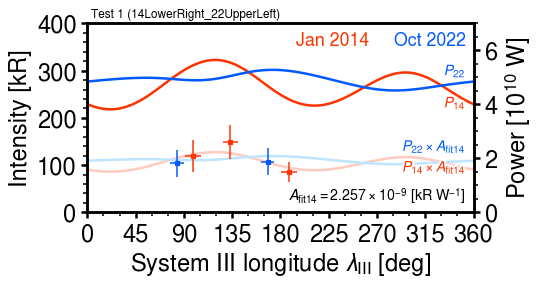

In [11]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(figsize=(5.0,2.7), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']

ax.set_xlim(0,360)
ax.set_ylim(0,400)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xticks(np.arange(0, 361, 45))
ax.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
ax.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
ax.set_yticks(np.arange(0,401,100,dtype=int))
ax.set_yticklabels(np.arange(0,401,100,dtype=int))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax.set_ylabel('Intensity [kR]', fontsize=fontsize)

# ======
# X AXIS
# ======
ax.set_xlabel(r"System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# BRIGHTNESS
# ==========
ax.text(0.01, 1.015, 'Test 1 (14LowerRight_22UpperLeft)', 
           color='k',
           horizontalalignment='left',
           verticalalignment='bottom',
           transform=ax.transAxes,
           fontsize=fontsize*0.5)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
doyname =['Jan 2014', None, None]+['Oct 2022', None]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)

    # リード角補正
    lead_data = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    eq_leadangle = lead_data[1,:]   # lead angle [deg]
    if doy[i] == '22/271_v18':
        # なぜかリード角のデータと1行目が合わない
        efplat0_arr = efplat0_arr[1:]
        efpwlong0_arr = efpwlong0_arr[1:]
        moons30_arr = moons30_arr[1:]
        b0_arr = b0_arr[1:]
        b1_arr = b1_arr[1:]
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    moon_leadback = moons30_arr-eq_leadangle
    moon_leadback_ave = np.average(moon_leadback)
    moon_leadback_std = np.std(moon_leadback)
    
    # ax.scatter(moon_leadback, b0_arr, marker=',', s=0.5, c=cud4_N[i], label=doyname[i], zorder=1)
    # ax.scatter(moon_leadback_ave, b0_ave, marker=',', s=15, c=cud4_N[i], label=doyname[i], zorder=1)
    ax.errorbar(moon_leadback_ave, b0_ave,
                xerr=moon_leadback_std, yerr=b0_std, label=doyname[i],
                marker='s', markersize=3.5, mfc=cud4_N[i], mec=cud4_N[i],
                linestyle='none', ecolor=cud4_N[i], elinewidth=1.2, zorder=1.5)
    print('S3 long. [deg]:', moon_leadback_ave)
    print('brightness [kR]:', b0_ave)
    print('1 sigma [kR]:', b0_std)

# =====
# POWER
# =====
pwr_14 = np.loadtxt('data/Power/14LowerRight_22UpperLeft/2014_R4_test1.txt')
pwr_22 = np.loadtxt('data/Power/14LowerRight_22UpperLeft/2022_R4_test1.txt')
ax2 = ax.twinx()
ax2.tick_params(axis='both', labelsize=fontsize)
ax2.set_ylim(0,7)
ax2.set_yticks(np.arange(0,7+1,2,dtype=int))
ax2.set_yticklabels(np.arange(0,7+1,2,dtype=int))
ax2.set_ylabel(r'Power [$10^{10}$ W]', fontsize=fontsize)
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))  # minor ticks
ax2.plot(pwr_14[0,:], pwr_14[1,:]*1E-10, linewidth=2.0, color=cud4[0], zorder=0.8)
ax2.plot(pwr_22[0,:], pwr_22[1,:]*1E-10, linewidth=2.0, color=cud4[3], zorder=0.8)
ax2.yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記

# ==============
# BRIGHTNESS FIT
# ==============
min_factor = 2.257142857142857e-09
ax.plot(pwr_14[0,:], pwr_14[1,:]*min_factor, linewidth=2.0, color=cud4bs[0], zorder=0.8)
ax.plot(pwr_22[0,:], pwr_22[1,:]*min_factor, linewidth=2.0, color=cud4bs[3], zorder=0.8)

# =======
# CAPTION
# =======
ax.text(0.73, 0.91, 'Jan 2014', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.75)
ax.text(0.98, 0.91, 'Oct 2022', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.75)
ax2.text(0.98, 0.58, r'$P_{14}$', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax2.text(0.98, 0.75, r'$P_{22}$', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax2.text(0.98, 0.24, r'$P_{14}\times A_{\rm fit14}$', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax2.text(0.98, 0.35, r'$P_{22}\times A_{\rm fit14}$', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax.transAxes,
           fontsize=fontsize*0.6,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax.text(0.98, 0.03, r'$A_{\rm fit14} = 2.257 \times 10^{-9}$ [kR W$^{-1}$]', 
           color='k',
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax.transAxes,
           fontsize=fontsize*0.6)

plt.show()

S3 long. [deg]: 133.42524957613273
brightness [kR]: 148.69104156172097
1 sigma [kR]: 35.95013950014683
S3 long. [deg]: 98.28193689058392
brightness [kR]: 119.48405134898138
1 sigma [kR]: 34.19465180990543
S3 long. [deg]: 187.72694177182828
brightness [kR]: 85.2057683162894
1 sigma [kR]: 21.60489879738368
S3 long. [deg]: 83.82101689698841
brightness [kR]: 103.65974592311026
1 sigma [kR]: 28.741229499
S3 long. [deg]: 168.0198387495764
brightness [kR]: 107.69670031940959
1 sigma [kR]: 27.960501902391933


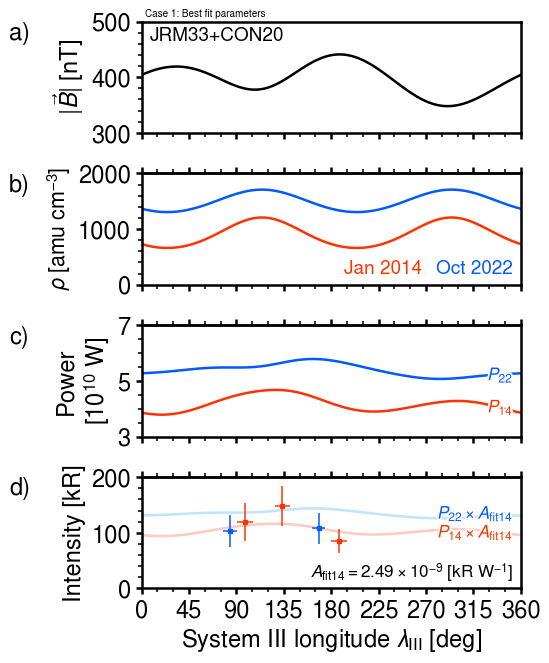

In [12]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(4,1, figsize=(5,6.9), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[i].set_xlabel(r"System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ========================
# FIRST PLOT - B MAGNITUDE
# ========================
B0_R4 = np.loadtxt('data/Power/B_R4.txt')
ax[0].text(0.01, 1.025, 'Case 1: Best fit parameters', 
           color='k',
           horizontalalignment='left',
           verticalalignment='bottom',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.42)
ax[0].set_ylim(300,500)
ax[0].set_yticks(np.arange(300,500+1,100,dtype=int))
ax[0].set_yticklabels(np.arange(300,500+1,100,dtype=int))
ax[0].set_ylabel(r'$|\vec{B}|$ [nT]', fontsize=fontsize)
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[0].plot(B0_R4[0,:], B0_R4[1,:]*1E+9, linewidth=2.0, color='k', zorder=0.8)

# =================
# SECOND PLOT - RHO
# =================
rho_14 = np.loadtxt('data/Power/rho_2014_R4.txt')
rho_22 = np.loadtxt('data/Power/rho_2022_R4.txt')
ax[1].set_ylim(0,2000)
ax[1].set_yticks(np.arange(0,2000+1,1000,dtype=int))
ax[1].set_yticklabels(np.arange(0,2000+1,1000,dtype=int))
ax[1].set_ylabel(r'$\rho$ [amu cm$^{-3}$]', fontsize=fontsize*0.9)
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[1].plot(rho_14[0,:], rho_14[1,:], linewidth=2.0, color=cud4[0], zorder=0.8)
ax[1].plot(rho_22[0,:], rho_22[1,:], linewidth=2.0, color=cud4[3], zorder=0.8)


# ==================
# THIRD PLOT - POWER
# ==================
pwr_14 = np.loadtxt('data/Power/2014_R4.txt')
pwr_22 = np.loadtxt('data/Power/2022_R4.txt')
ax[2].set_ylim(3,7)
ax[2].set_yticks(np.arange(3,7+1,2,dtype=int))
ax[2].set_yticklabels(np.arange(3,7+1,2,dtype=int))
ax[2].set_ylabel('Power\n[$10^{10}$ W]', fontsize=fontsize)
ax[2].yaxis.set_minor_locator(AutoMinorLocator(4))  # minor ticks
ax[2].plot(pwr_14[0,:], pwr_14[1,:]*1E-10, linewidth=2.0, color=cud4[0], zorder=0.8)
ax[2].plot(pwr_22[0,:], pwr_22[1,:]*1E-10, linewidth=2.0, color=cud4[3], zorder=0.8)
ax[2].yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記


# ========================
# FOURTH PLOT - BRIGHTNESS
# ========================
ax[3].set_ylim(0,200)
ax[3].set_yticks(np.arange(0,201,100,dtype=int))
ax[3].set_yticklabels(np.arange(0,201,100,dtype=int))
ax[3].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[3].set_ylabel('Intensity [kR]', fontsize=fontsize)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
doyname =['Jan 2014', None, None]+['Oct 2022', None]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)

    # リード角補正
    lead_data = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    eq_leadangle = lead_data[1,:]   # lead angle [deg]
    if doy[i] == '22/271_v18':
        # なぜかリード角のデータと1行目が合わない
        efplat0_arr = efplat0_arr[1:]
        efpwlong0_arr = efpwlong0_arr[1:]
        moons30_arr = moons30_arr[1:]
        b0_arr = b0_arr[1:]
        b1_arr = b1_arr[1:]
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    moon_leadback = moons30_arr-eq_leadangle
    moon_leadback_ave = np.average(moon_leadback)
    moon_leadback_std = np.std(moon_leadback)
    
    # ax.scatter(moon_leadback, b0_arr, marker=',', s=0.5, c=cud4_N[i], label=doyname[i], zorder=1)
    # ax.scatter(moon_leadback_ave, b0_ave, marker=',', s=15, c=cud4_N[i], label=doyname[i], zorder=1)
    ax[3].errorbar(moon_leadback_ave, b0_ave,
                xerr=moon_leadback_std, yerr=b0_std, label=doyname[i],
                marker='s', markersize=3.5, mfc=cud4_N[i], mec=cud4_N[i],
                linestyle='none', ecolor=cud4_N[i], elinewidth=1.2, zorder=1.5)
    print('S3 long. [deg]:', moon_leadback_ave)
    print('brightness [kR]:', b0_ave)
    print('1 sigma [kR]:', b0_std)

# ==============
# BRIGHTNESS FIT
# ==============
min_factor = 2.485714285714286e-09
ax[3].plot(pwr_14[0,:], pwr_14[1,:]*min_factor, linewidth=2.0, color=cud4bs[0], zorder=0.8)
ax[3].plot(pwr_22[0,:], pwr_22[1,:]*min_factor, linewidth=2.0, color=cud4bs[3], zorder=0.8)

# =======
# CAPTION
# =======
ax[0].text(0.02, 0.95, 'JRM33+CON20', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.74, 0.06, 'Jan 2014', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.98, 0.06, 'Oct 2022', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[2].text(0.98, 0.26, r'$P_{14}$', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax[2].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[2].text(0.98, 0.55, r'$P_{22}$', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax[2].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.98, 0.50, r'$P_{14}\times A_{\rm fit14}$', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.98, 0.67, r'$P_{22}\times A_{\rm fit14}$', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='center',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.98, 0.03, r'$A_{\rm fit14} = 2.49 \times 10^{-9}$ [kR W$^{-1}$]', 
           color='k',
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72)

plt.show()

S3 long. [deg]: 133.42524957613273
brightness [kR]: 148.69104156172097
1 sigma [kR]: 35.95013950014683
S3 long. [deg]: 98.28193689058392
brightness [kR]: 119.48405134898138
1 sigma [kR]: 34.19465180990543
S3 long. [deg]: 187.72694177182828
brightness [kR]: 85.2057683162894
1 sigma [kR]: 21.60489879738368
S3 long. [deg]: 83.82101689698841
brightness [kR]: 103.65974592311026
1 sigma [kR]: 28.741229499
S3 long. [deg]: 168.0198387495764
brightness [kR]: 107.69670031940959
1 sigma [kR]: 27.960501902391933


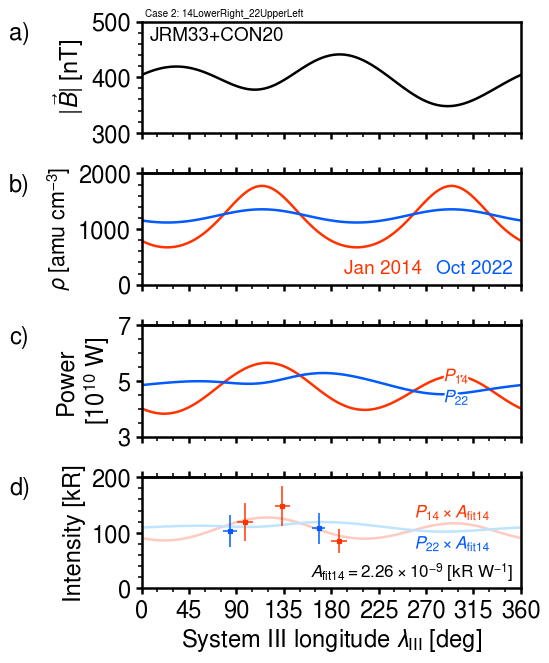

In [13]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(4,1, figsize=(5,6.9), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[i].set_xlabel(r"System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ========================
# FIRST PLOT - B MAGNITUDE
# ========================
B0_R4 = np.loadtxt('data/Power/B_R4.txt')
ax[0].text(0.01, 1.025, 'Case 2: 14LowerRight_22UpperLeft', 
           color='k',
           horizontalalignment='left',
           verticalalignment='bottom',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.42)
ax[0].set_ylim(300,500)
ax[0].set_yticks(np.arange(300,500+1,100,dtype=int))
ax[0].set_yticklabels(np.arange(300,500+1,100,dtype=int))
ax[0].set_ylabel(r'$|\vec{B}|$ [nT]', fontsize=fontsize)
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[0].plot(B0_R4[0,:], B0_R4[1,:]*1E+9, linewidth=2.0, color='k', zorder=0.8)

# =================
# SECOND PLOT - RHO
# =================
rho_14 = np.loadtxt('data/Power/14LowerRight_22UpperLeft/rho_2014_R4_test1.txt')
rho_22 = np.loadtxt('data/Power/14LowerRight_22UpperLeft/rho_2022_R4_test1.txt')
ax[1].set_ylim(0,2000)
ax[1].set_yticks(np.arange(0,2000+1,1000,dtype=int))
ax[1].set_yticklabels(np.arange(0,2000+1,1000,dtype=int))
ax[1].set_ylabel(r'$\rho$ [amu cm$^{-3}$]', fontsize=fontsize*0.9)
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[1].plot(rho_14[0,:], rho_14[1,:], linewidth=2.0, color=cud4[0], zorder=0.8)
ax[1].plot(rho_22[0,:], rho_22[1,:], linewidth=2.0, color=cud4[3], zorder=0.8)


# ==================
# THIRD PLOT - POWER
# ==================
pwr_14 = np.loadtxt('data/Power/14LowerRight_22UpperLeft/2014_R4_test1.txt')
pwr_22 = np.loadtxt('data/Power/14LowerRight_22UpperLeft/2022_R4_test1.txt')
ax[2].set_ylim(3,7)
ax[2].set_yticks(np.arange(3,7+1,2,dtype=int))
ax[2].set_yticklabels(np.arange(3,7+1,2,dtype=int))
ax[2].set_ylabel('Power\n[$10^{10}$ W]', fontsize=fontsize)
ax[2].yaxis.set_minor_locator(AutoMinorLocator(4))  # minor ticks
ax[2].plot(pwr_14[0,:], pwr_14[1,:]*1E-10, linewidth=2.0, color=cud4[0], zorder=0.8)
ax[2].plot(pwr_22[0,:], pwr_22[1,:]*1E-10, linewidth=2.0, color=cud4[3], zorder=0.8)
ax[2].yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記


# ========================
# FOURTH PLOT - BRIGHTNESS
# ========================
ax[3].set_ylim(0,200)
ax[3].set_yticks(np.arange(0,201,100,dtype=int))
ax[3].set_yticklabels(np.arange(0,201,100,dtype=int))
ax[3].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[3].set_ylabel('Intensity [kR]', fontsize=fontsize)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
doyname =['Jan 2014', None, None]+['Oct 2022', None]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)

    # リード角補正
    lead_data = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    eq_leadangle = lead_data[1,:]   # lead angle [deg]
    if doy[i] == '22/271_v18':
        # なぜかリード角のデータと1行目が合わない
        efplat0_arr = efplat0_arr[1:]
        efpwlong0_arr = efpwlong0_arr[1:]
        moons30_arr = moons30_arr[1:]
        b0_arr = b0_arr[1:]
        b1_arr = b1_arr[1:]
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    moon_leadback = moons30_arr-eq_leadangle
    moon_leadback_ave = np.average(moon_leadback)
    moon_leadback_std = np.std(moon_leadback)
    
    # ax.scatter(moon_leadback, b0_arr, marker=',', s=0.5, c=cud4_N[i], label=doyname[i], zorder=1)
    # ax.scatter(moon_leadback_ave, b0_ave, marker=',', s=15, c=cud4_N[i], label=doyname[i], zorder=1)
    ax[3].errorbar(moon_leadback_ave, b0_ave,
                xerr=moon_leadback_std, yerr=b0_std, label=doyname[i],
                marker='s', markersize=3.5, mfc=cud4_N[i], mec=cud4_N[i],
                linestyle='none', ecolor=cud4_N[i], elinewidth=1.2, zorder=1.5)
    print('S3 long. [deg]:', moon_leadback_ave)
    print('brightness [kR]:', b0_ave)
    print('1 sigma [kR]:', b0_std)

# ==============
# BRIGHTNESS FIT
# ==============
min_factor = 2.257142857142857e-09
ax[3].plot(pwr_14[0,:], pwr_14[1,:]*min_factor, linewidth=2.0, color=cud4bs[0], zorder=0.8)
ax[3].plot(pwr_22[0,:], pwr_22[1,:]*min_factor, linewidth=2.0, color=cud4bs[3], zorder=0.8)

# =======
# CAPTION
# =======
ax[0].text(0.02, 0.95, 'JRM33+CON20', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.74, 0.06, 'Jan 2014', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.98, 0.06, 'Oct 2022', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[2].text(0.83, 0.54, r'$P_{14}$', 
           color=cud4[0],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[2].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[2].text(0.83, 0.35, r'$P_{22}$', 
           color=cud4[3],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[2].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.82, 0.68, r'$P_{14}\times A_{\rm fit14}$', 
           color=cud4[0],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.82, 0.40, r'$P_{22}\times A_{\rm fit14}$', 
           color=cud4[3],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.98, 0.03, r'$A_{\rm fit14} = 2.26 \times 10^{-9}$ [kR W$^{-1}$]', 
           color='k',
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72)

plt.show()

S3 long. [deg]: 133.42524957613273
brightness [kR]: 148.69104156172097
1 sigma [kR]: 35.95013950014683
S3 long. [deg]: 98.28193689058392
brightness [kR]: 119.48405134898138
1 sigma [kR]: 34.19465180990543
S3 long. [deg]: 187.72694177182828
brightness [kR]: 85.2057683162894
1 sigma [kR]: 21.60489879738368
S3 long. [deg]: 83.82101689698841
brightness [kR]: 103.65974592311026
1 sigma [kR]: 28.741229499
S3 long. [deg]: 168.0198387495764
brightness [kR]: 107.69670031940959
1 sigma [kR]: 27.960501902391933


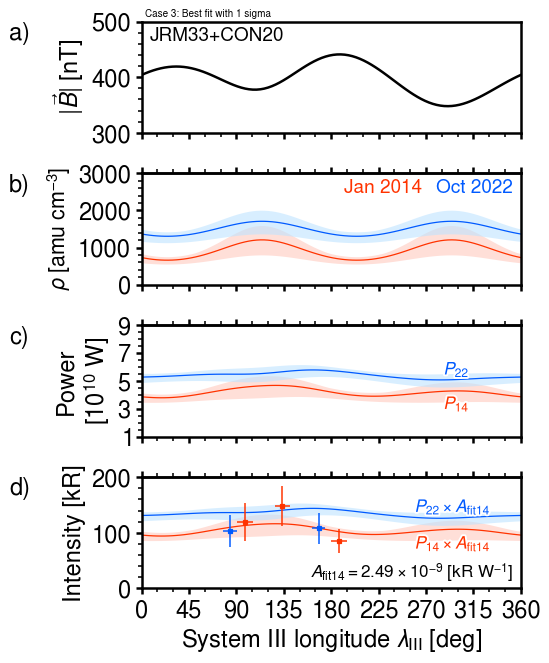

In [14]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(4,1, figsize=(5,6.9), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[i].set_xlabel(r"System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ========================
# FIRST PLOT - B MAGNITUDE
# ========================
B0_R4 = np.loadtxt('data/Power/B_R4.txt')
ax[0].text(0.01, 1.025, 'Case 3: Best fit with 1 sigma', 
           color='k',
           horizontalalignment='left',
           verticalalignment='bottom',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.42)
ax[0].set_ylim(300,500)
ax[0].set_yticks(np.arange(300,500+1,100,dtype=int))
ax[0].set_yticklabels(np.arange(300,500+1,100,dtype=int))
ax[0].set_ylabel(r'$|\vec{B}|$ [nT]', fontsize=fontsize)
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[0].plot(B0_R4[0,:], B0_R4[1,:]*1E+9, linewidth=2.0, color='k', zorder=0.8)

# =================
# SECOND PLOT - RHO
# =================
rho_14 = np.loadtxt('data/Power/rho_2014_R4.txt')
rho_22 = np.loadtxt('data/Power/rho_2022_R4.txt')
ax[1].set_ylim(0,3000)
ax[1].set_yticks(np.arange(0,3000+1,1000,dtype=int))
ax[1].set_yticklabels(np.arange(0,3000+1,1000,dtype=int))
ax[1].set_ylabel(r'$\rho$ [amu cm$^{-3}$]', fontsize=fontsize*0.9)
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[1].plot(rho_14[0,:], rho_14[1,:], linewidth=1.0, color=cud4[0], zorder=0.8)
ax[1].plot(rho_22[0,:], rho_22[1,:], linewidth=1.0, color=cud4[3], zorder=0.8)
rho_14_arr = np.zeros((10,rho_14[1,:].size))
rho_22_arr = np.zeros((10,rho_22[1,:].size))
for i in range(10):
    rho_14_1 = np.loadtxt('data/Power/1s_rand/rho_2014_R4_rand'+str(i)+'.txt')
    rho_22_1 = np.loadtxt('data/Power/1s_rand/rho_2022_R4_rand'+str(i)+'.txt')
    rho_14_arr[i,:] = rho_14_1[1,:]
    rho_22_arr[i,:] = rho_22_1[1,:]
ax[1].fill_between(x=pwr_14[0,:], 
                    y1=rho_14_arr.max(axis=0),
                    y2=rho_14_arr.min(axis=0),
                    alpha=0.6,
                    color=cud4bs[0],
                    edgecolor=None,
                    zorder=0.6,)
ax[1].fill_between(x=pwr_22[0,:], 
                    y1=rho_22_arr.max(axis=0),
                    y2=rho_22_arr.min(axis=0),
                    alpha=0.6,
                    color=cud4bs[3],
                    edgecolor=None,
                    zorder=0.6,)


# ==================
# THIRD PLOT - POWER
# ==================
pwr_14 = np.loadtxt('data/Power/2014_R4.txt')
pwr_22 = np.loadtxt('data/Power/2022_R4.txt')
ax[2].set_ylim(1,9)
ax[2].set_yticks(np.arange(1,9+1,2,dtype=int))
ax[2].set_yticklabels(np.arange(1,9+1,2,dtype=int))
ax[2].set_ylabel('Power\n[$10^{10}$ W]', fontsize=fontsize)
ax[2].yaxis.set_minor_locator(AutoMinorLocator(4))  # minor ticks
ax[2].plot(pwr_14[0,:], pwr_14[1,:]*1E-10, linewidth=1.0, color=cud4[0], zorder=0.8)
ax[2].plot(pwr_22[0,:], pwr_22[1,:]*1E-10, linewidth=1.0, color=cud4[3], zorder=0.8)
ax[2].yaxis.set_major_formatter(
        ptick.ScalarFormatter(useMathText=True))    # 指数表記
pwr_14_arr = np.zeros((10,pwr_14[1,:].size))
pwr_22_arr = np.zeros((10,pwr_22[1,:].size))
for i in range(10):
    pwr_14_1 = np.loadtxt('data/Power/1s_rand/2014_R4_rand'+str(i)+'.txt')
    pwr_22_1 = np.loadtxt('data/Power/1s_rand/2022_R4_rand'+str(i)+'.txt')
    pwr_14_arr[i,:] = pwr_14_1[1,:]
    pwr_22_arr[i,:] = pwr_22_1[1,:]
ax[2].fill_between(x=pwr_14[0,:], 
                    y1=pwr_14_arr.max(axis=0)*1E-10,
                    y2=pwr_14_arr.min(axis=0)*1E-10,
                    alpha=0.6,
                    color=cud4bs[0],
                    edgecolor=None,
                    zorder=0.6,)
ax[2].fill_between(x=pwr_22[0,:], 
                    y1=pwr_22_arr.max(axis=0)*1E-10,
                    y2=pwr_22_arr.min(axis=0)*1E-10,
                    alpha=0.6,
                    color=cud4bs[3],
                    edgecolor=None,
                    zorder=0.6,)


# ========================
# FOURTH PLOT - BRIGHTNESS
# ========================
ax[3].set_ylim(0,200)
ax[3].set_yticks(np.arange(0,201,100,dtype=int))
ax[3].set_yticklabels(np.arange(0,201,100,dtype=int))
ax[3].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
ax[3].set_ylabel('Intensity [kR]', fontsize=fontsize)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
cud4_N = [cud4[0], cud4[0], cud4[0], cud4[3], cud4[3]]
doyname =['Jan 2014', None, None]+['Oct 2022', None]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)

    # リード角補正
    lead_data = np.loadtxt('data/red3_leadangle/EUROPA/20'+doy[i]+'_eq.txt')
    eq_leadangle = lead_data[1,:]   # lead angle [deg]
    if doy[i] == '22/271_v18':
        # なぜかリード角のデータと1行目が合わない
        efplat0_arr = efplat0_arr[1:]
        efpwlong0_arr = efpwlong0_arr[1:]
        moons30_arr = moons30_arr[1:]
        b0_arr = b0_arr[1:]
        b1_arr = b1_arr[1:]
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    moon_leadback = moons30_arr-eq_leadangle
    moon_leadback_ave = np.average(moon_leadback)
    moon_leadback_std = np.std(moon_leadback)
    
    # ax.scatter(moon_leadback, b0_arr, marker=',', s=0.5, c=cud4_N[i], label=doyname[i], zorder=1)
    # ax.scatter(moon_leadback_ave, b0_ave, marker=',', s=15, c=cud4_N[i], label=doyname[i], zorder=1)
    ax[3].errorbar(moon_leadback_ave, b0_ave,
                xerr=moon_leadback_std, yerr=b0_std, label=doyname[i],
                marker='s', markersize=3.5, mfc=cud4_N[i], mec=cud4_N[i],
                linestyle='none', ecolor=cud4_N[i], elinewidth=1.2, zorder=1.5)
    print('S3 long. [deg]:', moon_leadback_ave)
    print('brightness [kR]:', b0_ave)
    print('1 sigma [kR]:', b0_std)


# ==============
# BRIGHTNESS FIT
# ==============
min_factor = 2.485714285714286e-09
ax[3].plot(pwr_14[0,:], pwr_14[1,:]*min_factor, linewidth=1.0, color=cud4[0], zorder=0.8)
ax[3].plot(pwr_22[0,:], pwr_22[1,:]*min_factor, linewidth=1.0, color=cud4[3], zorder=0.8)
pwr_14_arr = np.zeros((10,pwr_14[1,:].size))
pwr_22_arr = np.zeros((10,pwr_22[1,:].size))
for i in range(10):
    pwr_14_1 = np.loadtxt('data/Power/1s_rand/2014_R4_rand'+str(i)+'.txt')
    pwr_22_1 = np.loadtxt('data/Power/1s_rand/2022_R4_rand'+str(i)+'.txt')
    pwr_14_arr[i,:] = pwr_14_1[1,:]
    pwr_22_arr[i,:] = pwr_22_1[1,:]
ax[3].fill_between(x=pwr_14[0,:], 
                    y1=pwr_14_arr.max(axis=0)*min_factor,
                    y2=pwr_14_arr.min(axis=0)*min_factor,
                    alpha=0.6,
                    color=cud4bs[0],
                    edgecolor=None,
                    zorder=0.6,)
ax[3].fill_between(x=pwr_22[0,:], 
                    y1=pwr_22_arr.max(axis=0)*min_factor,
                    y2=pwr_22_arr.min(axis=0)*min_factor,
                    alpha=0.6,
                    color=cud4bs[3],
                    edgecolor=None,
                    zorder=0.6,)


# =======
# CAPTION
# =======
ax[0].text(0.02, 0.95, 'JRM33+CON20', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.74, 0.95, 'Jan 2014', 
           color=cud4[0],
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[1].text(0.98, 0.95, 'Oct 2022', 
           color=cud4[3],
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.8)
ax[2].text(0.83, 0.29, r'$P_{14}$', 
           color=cud4[0],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[2].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[2].text(0.83, 0.60, r'$P_{22}$', 
           color=cud4[3],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[2].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.82, 0.40, r'$P_{14}\times A_{\rm fit14}$', 
           color=cud4[0],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.82, 0.73, r'$P_{22}\times A_{\rm fit14}$', 
           color=cud4[3],
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72,
           path_effects=[pe.withStroke(linewidth=3, foreground='#FFFFFF')],)
ax[3].text(0.98, 0.03, r'$A_{\rm fit14} = 2.49 \times 10^{-9}$ [kR W$^{-1}$]', 
           color='k',
           horizontalalignment='right',
           verticalalignment='bottom',
           transform=ax[3].transAxes,
           fontsize=fontsize*0.72)

plt.show()

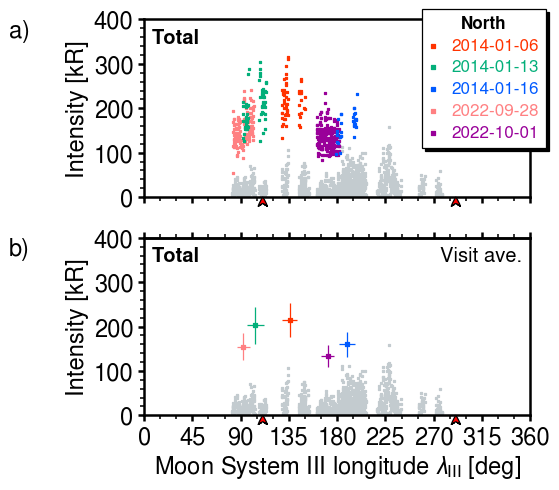

In [15]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].set_ylim(0,400)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.arange(0,401,100,dtype=int))
    ax[i].set_yticklabels(np.arange(0,401,100,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, 'Total', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2014-01-06', '2014-01-13', '2014-01-16']+['2022-09-28', '2022-10-01']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr+b1_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=10-i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=1,
                    markerscale=3.5,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Total', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    b1_std = np.std(b1_arr)
    b2_arr = b0_arr + b1_arr
    b2_ave = np.average(b2_arr)
    b2_std = np.std(b2_arr)
    ax[1].scatter(moons30_ave, b2_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
    ax[1].errorbar(moons30_ave, b2_ave, xerr=moons30_std, yerr=b2_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()

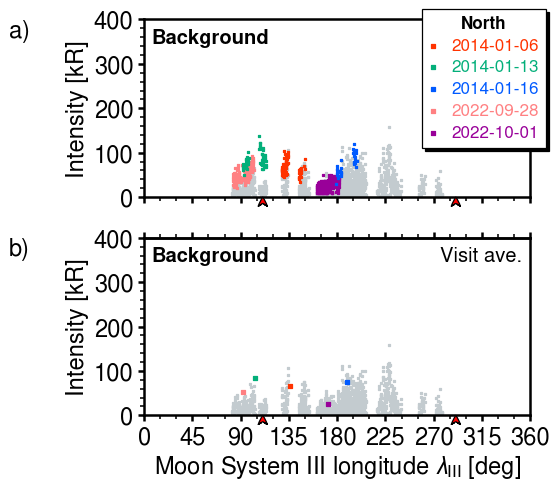

In [16]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].set_ylim(0,400)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.arange(0,401,100,dtype=int))
    ax[i].set_yticklabels(np.arange(0,401,100,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, 'Background', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2014-01-06', '2014-01-13', '2014-01-16']+['2022-09-28', '2022-10-01']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b1_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=10-i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=1,
                    markerscale=3.5,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Background', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b1_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()

### 南半球 発光強度 (横軸: EuropaのS3経度)

In [17]:
hem = 'South'
if hem == 'North':
    doy = north_doy
    bkgdoy = nbkg_doy
    bon17 = '0006'
elif hem == 'South':
    doy = south_doy
    bkgdoy = sbkg_doy
    bon17 = '0007'
else:
    doy = north_doy+south_doy
    bkgdoy = nbkg_doy+sbkg_doy

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

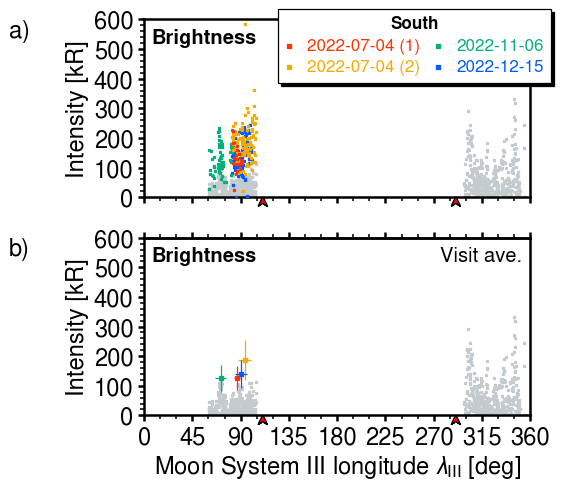

In [18]:
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].set_ylim(0, 600)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.arange(0,601,100,dtype=int))
    ax[i].set_yticklabels(np.arange(0,601,100,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[6], cud4[2], cud4[3]]
doyname = ['2022-07-04 (1)', '2022-07-04 (2)', '2022-11-06', '2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=20-i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=2,
                    markerscale=3.5,
                    bbox_to_anchor=(0.70, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    columnspacing=0.8,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('South', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[6], cud4[2], cud4[3]]
doyname = ['2022-07-04 (1)', '2022-07-04 (2)', '2022-11-06', '2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    ax[1].scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
    ax[1].errorbar(moons30_ave, b0_ave, xerr=moons30_std, yerr=b0_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))

plt.show()

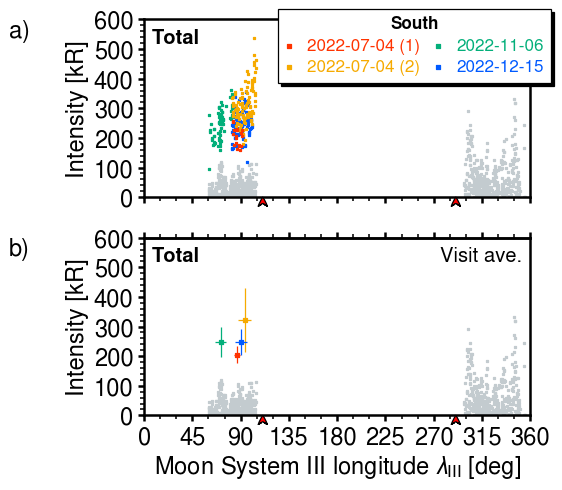

In [19]:
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].set_ylim(0, 600)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.arange(0,601,100,dtype=int))
    ax[i].set_yticklabels(np.arange(0,601,100,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, 'Total', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[6], cud4[2], cud4[3]]
doyname = ['2022-07-04 (1)', '2022-07-04 (2)', '2022-11-06', '2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr+b1_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=20-i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=2,
                    markerscale=3.5,
                    bbox_to_anchor=(0.70, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    columnspacing=0.8,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('South', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Total', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[6], cud4[2], cud4[3]]
doyname = ['2022-07-04 (1)', '2022-07-04 (2)', '2022-11-06', '2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    b1_std = np.std(b1_arr)
    b2_arr = b0_arr + b1_arr
    b2_ave = np.average(b2_arr)
    b2_std = np.std(b2_arr)
    ax[1].scatter(moons30_ave, b2_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
    ax[1].errorbar(moons30_ave, b2_ave, xerr=moons30_std, yerr=b2_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)


# =====================
# PLASMA SHEET CROSSING
# =====================
for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()

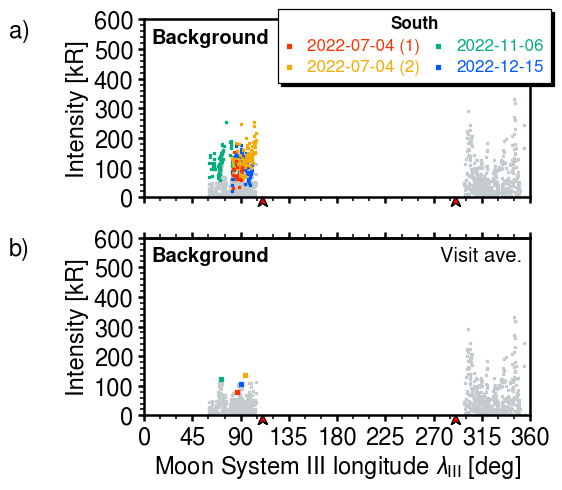

In [20]:
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0, 360)
    ax[i].set_ylim(0, 600)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.arange(0,601,100,dtype=int))
    ax[i].set_yticklabels(np.arange(0,601,100,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, 'Background', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[6], cud4[2], cud4[3]]
doyname = ['2022-07-04 (1)', '2022-07-04 (2)', '2022-11-06', '2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b1_arr, marker=',', s=1.0, c=cud4_N[i], label=doyname[i], zorder=20-i)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=2,
                    markerscale=3.5,
                    bbox_to_anchor=(0.70, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    columnspacing=0.8,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('South', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Background', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[6], cud4[2], cud4[3]]
doyname = ['2022-07-04 (1)', '2022-07-04 (2)', '2022-11-06', '2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/EUROPA/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_ave = np.average(efplat0_arr[idx])
    efpwlong0_ave = np.average(efpwlong0_arr[idx])
    moons30_ave = np.average(moons30_arr[idx])
    b0_ave = np.average(b0_arr[idx])
    b1_ave = np.average(b1_arr[idx])
    ax[1].scatter(moons30_ave, b1_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
for i in range(len(bkgdoy)):
    csvname0 = 'img/bkgS3/EUROPA/20'+bkgdoy[i]+'/brightness.csv'         # Brightness at the model spot
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[1].scatter(moons30_arr, b0_arr, marker=',', s=1.0, c='#C3CBCF', zorder=0.8)
# ax[1].axvline(x=110.61452513966482, color='#cfcfcf', zorder=0.5)
# ax[1].axvline(x=110.61452513966482+180, color='#cfcfcf', zorder=0.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()

# 北半球 GFP (2022-12-15)

In [21]:
hem = 'North'
doy = ['22/349_v24']

refnum = 0
if hem == 'South':
    refnum = 1
satoval = np.recfromtxt('ref/2021je007055-sup-000'+str(3+refnum)+'-table si-s0'+str(2+refnum)+'.txt', skip_header=3,
                names=['wlon', 'amlat', 'amwlon', 'iolat', 'iowlon', 'eulat', 'euwlon', 'galat', 'gawlon'])

xing_s3wlon_110 = ftpS3.ftpS3().FPW(110.61452513966482, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(110.61452513966482+180, satoval, 'EUROPA')

xing_s3wlon_110 = ftpS3.ftpS3().FPW(114.2, satoval, 'EUROPA')
xing_s3wlon_290 = ftpS3.ftpS3().FPW(114.2+180, satoval, 'EUROPA')

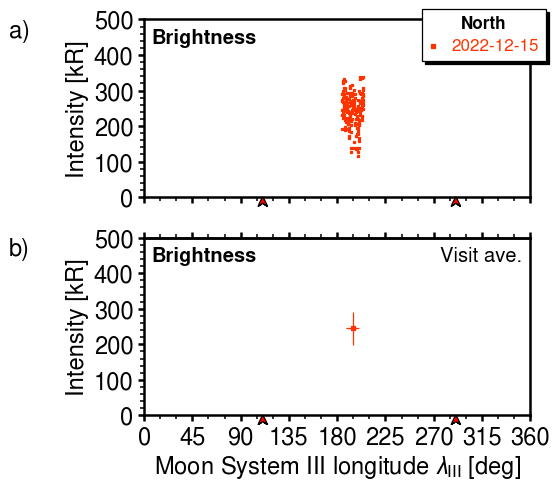

In [22]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(0,360)
    ax[i].set_ylim(0,500)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(0, 361, 45))
    ax[i].set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.linspace(0,500,6,dtype=int))
    ax[i].set_yticklabels(np.linspace(0,500,6,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, r'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/GANYMEDE/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=0.8, c=cud4_N[i], label=doyname[i], zorder=10-i)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=1,
                    markerscale=3.5,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/GANYMEDE/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    ax[1].scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
    ax[1].errorbar(moons30_ave, b0_ave, xerr=moons30_std, yerr=b0_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()

経度範囲を狭めてプロットを拡大

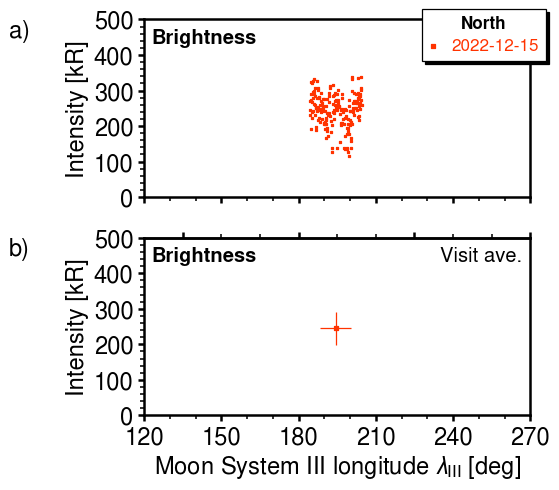

In [23]:
# ----- 1枚目のパネル -----
fontsize = 19
fig, ax = plt.subplots(2,1, figsize=(5,5), dpi=90)

fig.tight_layout()
panelname = ['a','b','c','d','e','f','g','h']
for i in range(ax.size):
    ax[i].set_xlim(120,270)
    ax[i].set_ylim(0,500)
    ax[i].tick_params(axis='both', labelsize=fontsize)
    ax[i].set_xticks(np.arange(120, 271, 30))
    ax[i].set_xticklabels(np.arange(120, 271, 30), fontsize=fontsize)
    ax[i].xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
    ax[i].set_yticks(np.linspace(0,500,6,dtype=int))
    ax[i].set_yticklabels(np.linspace(0,500,6,dtype=int))
    ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))  # minor ticks
    ax[i].set_ylabel('Intensity [kR]', fontsize=fontsize)
    if i != 0:
        ax2 = ax[i].secondary_xaxis('top')
        ax2.set_xticks(np.arange(0, 361, 45))
        ax2.set_xticklabels(np.arange(0, 361, 45), fontsize=fontsize)
        ax2.xaxis.set_minor_locator(AutoMinorLocator(3))  # minor ticks
        plt.setp(ax2.get_xticklabels(), visible=False)  # ラベルを消す
    if i != ax.size-1:
        plt.setp(ax[i].get_xticklabels(), visible=False)  # ラベルを消す
    ax[i].text(-0.35, 1.0, panelname[i]+')', color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[i].transAxes,
           fontsize=fontsize)

# ======
# X AXIS
# ======
ax[1].set_xlabel(r"Moon System III longitude $\lambda_{\rm III}$ [deg]", fontsize=fontsize)

# ==========
# FIRST PLOT
# ==========
ax[0].text(0.02, 0.95, r'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[0].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
doyname =['2022-12-15']
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/GANYMEDE/20'+doy[i]+'/brightness.csv'   # Footprint aurora brightness
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    ax[0].scatter(moons30_arr, b0_arr, marker=',', s=0.8, c=cud4_N[i], label=doyname[i], zorder=10-i)

legend_fsize = fontsize*0.72
legend1 = ax[0].legend(loc='upper center',
                    ncol=1,
                    markerscale=3.5,
                    bbox_to_anchor=(0.88, 1.11),
                    fancybox=False,
                    facecolor='white',
                    framealpha=1,
                    edgecolor='k',
                    fontsize=legend_fsize,
                    labelspacing=0.34,
                    handlelength=0.5,
                    scatterpoints=1, )
legend1.set_title('North', prop={'size': legend_fsize, 'weight': 'bold'})
legend_shadow(fig, ax[0], legend1, dx=0.007, dy=-0.007)

# get contour colors
i = 0
for leg1text in legend1.get_texts():
    leg1text.set_color(cud4_N[i])
    i += 1


# ===========
# SECOND PLOT
# ===========
ax[1].text(0.02, 0.95, 'Brightness', weight='bold',
           color='k',
           horizontalalignment='left',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
ax[1].text(0.98, 0.95, 'Visit ave.', color='k',
           horizontalalignment='right',
           verticalalignment='top',
           transform=ax[1].transAxes,
           fontsize=fontsize*0.85)
cud4_N = [cud4[0], cud4[2], cud4[3], cud4[5], cud4[7]]
for i in range(len(doy)):
    csvname0 = 'img/red3_half2/GANYMEDE/20'+doy[i]+'/brightness.csv'
    utc, b0_arr, b1_arr, efplat0_arr, efpwlong0_arr, moons30_arr = load(csvname0)
    idx = np.where(b0_arr>0)
    efplat0_arr = efplat0_arr[idx]
    efpwlong0_arr = efpwlong0_arr[idx]
    moons30_arr = moons30_arr[idx]
    efplat0_ave = np.average(efplat0_arr)
    efpwlong0_ave = np.average(efpwlong0_arr)
    moons30_ave = np.average(moons30_arr)
    moons30_std = np.std(moons30_arr)
    b0_arr = b0_arr[idx]
    b1_arr = b1_arr[idx]
    b0_ave = np.average(b0_arr)
    b1_ave = np.average(b1_arr)
    b0_std = np.std(b0_arr)
    ax[1].scatter(moons30_ave, b0_ave, marker=',', s=15.0, c=cud4_N[i], label=doy[i], zorder=1)
    ax[1].errorbar(moons30_ave, b0_ave, xerr=moons30_std, yerr=b0_std,
                   linestyle='none', ecolor=cud4_N[i], elinewidth=1.0, marker='none', zorder=1.5)

for i in range(2):
    ax[0].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    ax[1].annotate('',
                xy=(110.61452513966482+180*i, 0), xycoords='data',
                xytext=(110.61452513966482+180*i, -1), textcoords='data',
                size=18,
                arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3', fc='r', clip_on=True))
    
plt.show()